#    EMPIK prediction task solution by Mateusz Falkowski

**Libraries and data**

In [1]:
library(ggplot2)
library(dplyr)
library(splitstackshape)
data <- read.csv("https://raw.githubusercontent.com/falkini17/empik_case_study/master/bank_data_prediction_task.csv")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'splitstackshape' was built under R version 3.6.3"

# Initial analysis and data manipulation

To start with I check the structure and summary of data

In [2]:
str(data)
summary(data)

'data.frame':	41188 obs. of  23 variables:
 $ X                : int  1 2 3 4 5 6 7 8 9 10 ...
 $ age              : int  37 45 59 25 35 54 55 37 35 39 ...
 $ job              : Factor w/ 12 levels "admin.","blue-collar",..: 8 8 1 8 2 6 2 1 10 7 ...
 $ marital          : Factor w/ 4 levels "divorced","married",..: 2 2 2 3 2 2 2 2 2 2 ...
 $ education        : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 6 4 2 3 1 4 7 3 ...
 $ default          : Factor w/ 3 levels "no","unknown",..: 1 2 1 1 1 2 2 1 1 2 ...
 $ housing          : Factor w/ 3 levels "no","unknown",..: 3 1 1 3 3 3 3 3 1 1 ...
 $ loan             : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 3 1 1 3 1 ...
 $ contact          : Factor w/ 2 levels "cellular","telephone": 2 2 2 2 2 2 2 2 2 2 ...
 $ month            : Factor w/ 10 levels "apr","aug","dec",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ day_of_week      : Factor w/ 5 levels "fri","mon","thu",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ duration         : int  226 198 139 50 146 174 262

       X              age                 job            marital     
 Min.   :    1   Min.   :17.00   admin.     :10422   divorced: 4612  
 1st Qu.:10298   1st Qu.:32.00   blue-collar: 9254   married :24928  
 Median :20595   Median :38.00   technician : 6743   single  :11568  
 Mean   :20595   Mean   :40.02   services   : 3969   unknown :   80  
 3rd Qu.:30891   3rd Qu.:47.00   management : 2924                   
 Max.   :41188   Max.   :98.00   retired    : 1720                   
                                 (Other)    : 6156                   
               education        default         housing           loan      
 university.degree  :12168   no     :32588   no     :18622   no     :33950  
 high.school        : 9515   unknown: 8597   unknown:  990   unknown:  990  
 basic.9y           : 6045   yes    :    3   yes    :21576   yes    : 6248  
 professional.course: 5243                                                  
 basic.4y           : 4176                             

After taking a look at the variables y and test_control_flag indicating the purchase and being treated with campaign I create their **converegence table**. Worth noticing is the fact of significant number of NA's in the variables: contact, month, day_of_week, duration and campaign. They correspond to the fact that this data was not gathered in the control group. Moreover, some NA's in cons.price.idx should be tackled in the course of the analysis.

In [3]:
(t <- prop.table(table(data$test_control_flag,data$y),1))
(net_effect <- t[1,2]-t[2,2])

                
                         no        yes
  campaign group 0.88735130 0.11264870
  control group  0.90757527 0.09242473

[1] 0.02022397

It appears that the proportion of the clients who purchased the product within campaign group is **app. 2% higher than in the control group. So the campaign seems to be effective in general.** However, I need to take a closer look on the counts within these groups.

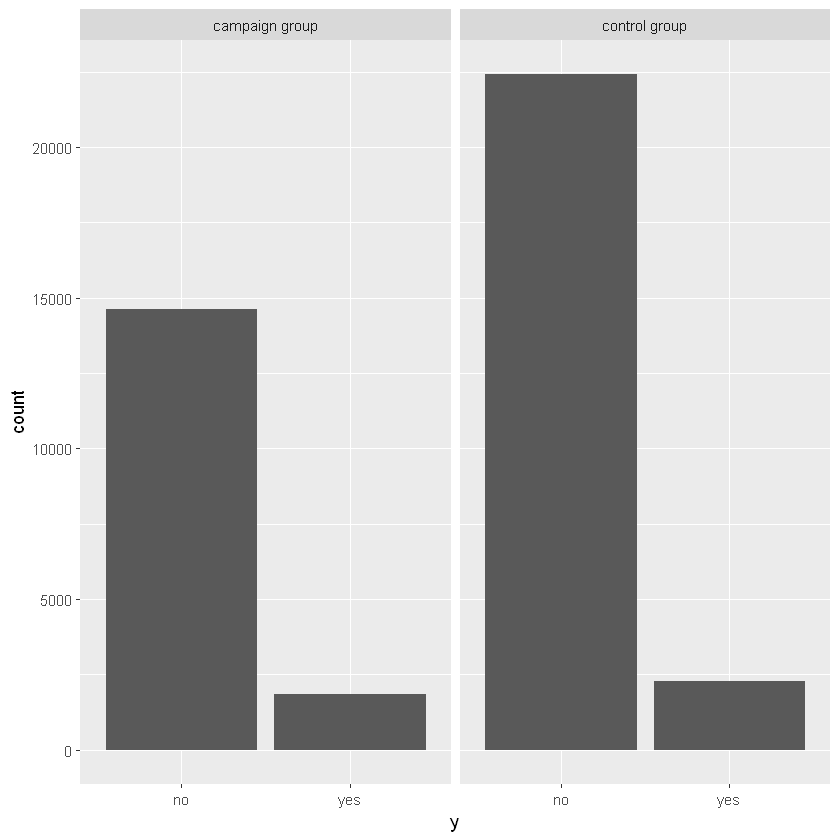

In [4]:
ggplot(data,aes(x=y)) + geom_bar() + facet_wrap(~test_control_flag)

Seems like the control group is in general slightly bigger. Another variable I need to take a closer look at is _pdays_ - number of days that passed by after the client was last contacted from a previous campaign. As it's a numeric variable with max 999 (meaning the client was not previously contacted at all) I need to convert it into categorical one, because 999 will skew my dataset.

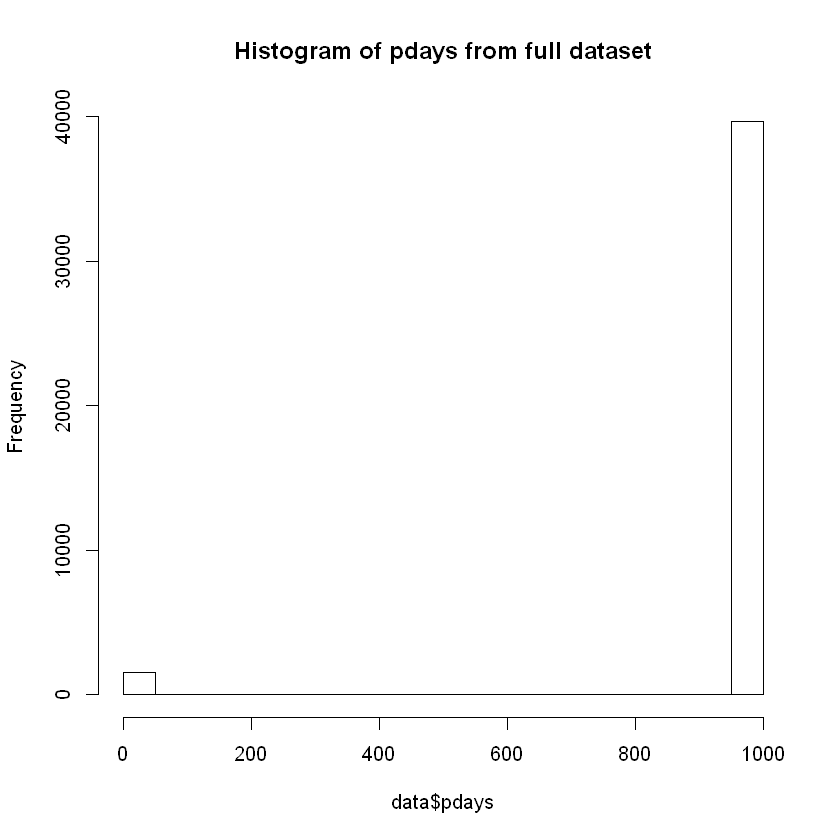

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   6.000   6.015   7.000  27.000 

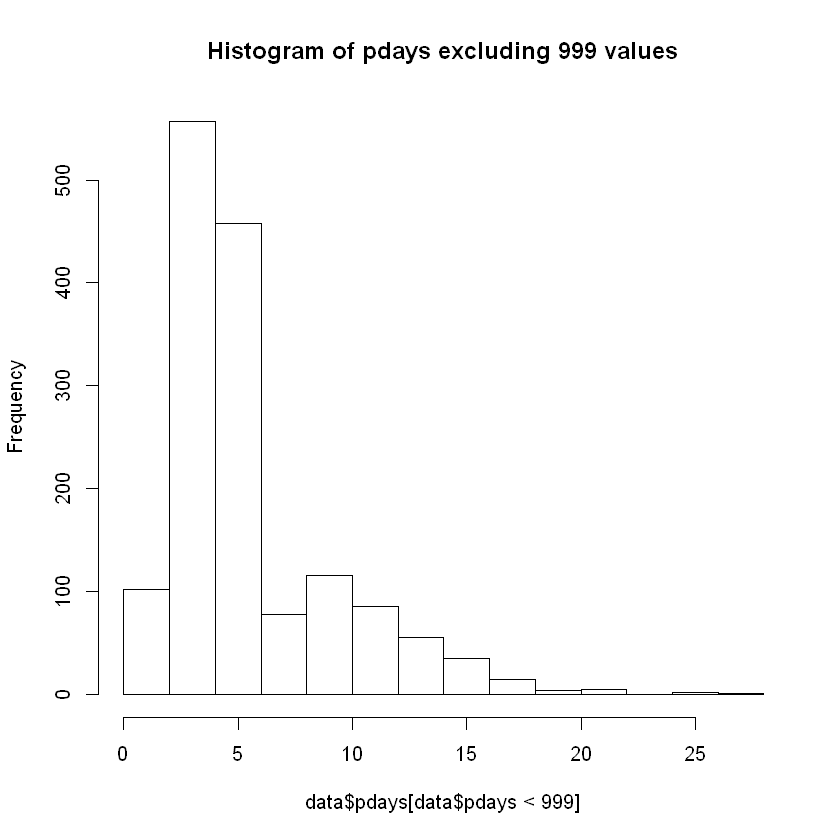

In [5]:
hist(data$pdays, main = "Histogram of pdays from full dataset")
hist(data$pdays[data$pdays<999], main = "Histogram of pdays excluding 999 values")
summary(data$pdays[data$pdays<999])

So most of the clients has never been contacted before. So I chose to recode this variable into three categories: 
<ol>
<li>"last week" - somebody was contacted within last 7 days,</li>
<li>"earlier than week ago" - somebody was contacted earlier than a week ago</li>
<li>"never" - somebody has never before been contacted</li>
</ol>
I also changed the values of our dependent variable y to 0 and 1.

In [6]:
data$y <- as.integer(data$y)
data <- data %>%
  mutate(pdays = case_when(pdays<=7 ~ "last week",
                            pdays<999 & pdays>7 ~ "earlier than week ago",
                            pdays>=999 ~ "never"),
         y = case_when(y==1 ~ 0,
                       y==2 ~ 1))
data$pdays <- as.factor(data$pdays)  
table(data$pdays)
data$y <- as.integer(data$y)


earlier than week ago             last week                 never 
                  338                  1177                 39673 

The next step is spliting our data into training and testing dataset. The important part of it is to stick to the proportion of control/campaign groups and y outcomes. 

In [7]:
set.seed(1)
train_test_split <- stratified(data, group = c("test_control_flag","y"),size=0.7,bothSets = T)
train <- train_test_split[[1]]
test <- train_test_split[[2]]
prop.table(table(train$test_control_flag,train$y),1)
prop.table(table(test$test_control_flag,test$y),1)

                
                          0          1
  campaign group 0.88736669 0.11263331
  control group  0.90756691 0.09243309

                
                          0          1
  campaign group 0.88731540 0.11268460
  control group  0.90759477 0.09240523

# Logistic regression (two-model approach)

My approach to this task is to create two models. One will use use only control group observations to train predicting the y outcome. The second one will use only campaign group observations to train predicting the y outcome. Then I will use the testing dataset twice and compare the predictions to calculate the uplift from treating clients with campaign. My first try would be a logistic regression.

In [8]:
control_log <- glm(y~.,
                   data=train[test_control_flag=="control group",-c("test_control_flag","contact","month","day_of_week","duration","campaign")],
                   family = "binomial")
summary(control_log)

campaign_log <- glm(y~.,
    data=train[test_control_flag=="campaign group",-c("test_control_flag","contact","month","day_of_week","duration","campaign")],
    family = "binomial")
summary(campaign_log)



Call:
glm(formula = y ~ ., family = "binomial", data = train[test_control_flag == 
    "control group", -c("test_control_flag", "contact", "month", 
    "day_of_week", "duration", "campaign")])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7670  -0.3884  -0.2914  -0.2525   2.8497  

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -1.003e+02  2.211e+01  -4.536 5.73e-06 ***
X                             7.011e-05  1.058e-05   6.630 3.36e-11 ***
age                           2.023e-03  3.435e-03   0.589 0.555794    
jobblue-collar               -3.506e-01  1.142e-01  -3.069 0.002149 ** 
jobentrepreneur              -7.848e-03  1.710e-01  -0.046 0.963392    
jobhousemaid                 -3.715e-01  2.235e-01  -1.662 0.096447 .  
jobmanagement                -1.865e-01  1.254e-01  -1.487 0.137076    
jobretired                    3.065e-01  1.506e-01   2.035 


Call:
glm(formula = y ~ ., family = "binomial", data = train[test_control_flag == 
    "campaign group", -c("test_control_flag", "contact", "month", 
    "day_of_week", "duration", "campaign")])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9540  -0.4218  -0.3209  -0.2666   2.8103  

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -4.648e+01  2.646e+01  -1.757 0.079000 .  
X                             1.075e-04  1.795e-05   5.991 2.09e-09 ***
age                           4.206e-04  4.027e-03   0.104 0.916821    
jobblue-collar               -1.032e-01  1.280e-01  -0.806 0.419987    
jobentrepreneur              -1.591e-01  2.069e-01  -0.769 0.441973    
jobhousemaid                  1.413e-01  2.252e-01   0.627 0.530350    
jobmanagement                -1.394e-02  1.367e-01  -0.102 0.918727    
jobretired                    3.151e-02  1.806e-01   0.175

The reason I'm omitting the variables related to current campaign is that I cannot use them for control group model and I want my models to be exactly the same. Now I will predict the outcomes basing on those two models.

In [9]:
control_prediction_log <- predict(control_log,
                     newdata = test[,-c("test_control_flag","contact","month","day_of_week","duration","campaign")],
                     type = "response")
campaign_prediction_log <- predict(campaign_log,
                               newdata = test[,-c("test_control_flag","contact","month","day_of_week","duration","campaign")],
                               type = "response")


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Now I would like to compare the outcomes and see what is the effect of addressing customers with marketing campaign.

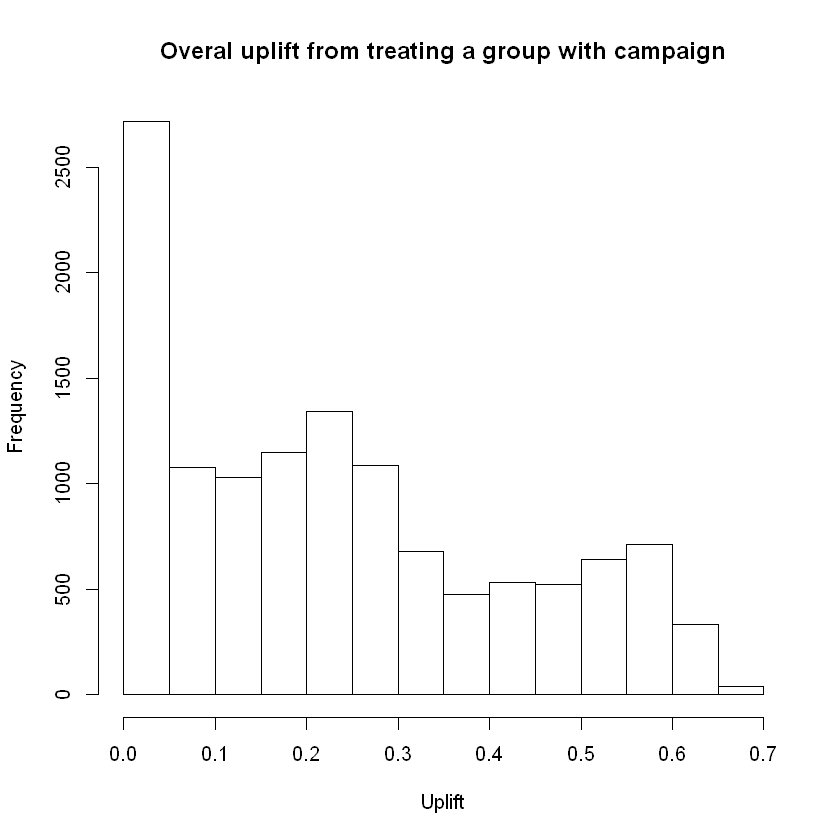

In [10]:
hist(campaign_prediction_log-control_prediction_log,main = "Overal uplift from treating a group with campaign", xlab = "Uplift")


It seems like marketing has only positive effect on the probability of purchasing the product. **This seems weird to me, so I will take a closer look on the model fitness**. I present some of the metrics evaluating the model efficiency.

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 11018  1138
         1    66   104
                                          
               Accuracy : 0.9023          
                 95% CI : (0.8969, 0.9075)
    No Information Rate : 0.8992          
    P-Value [Acc > NIR] : 0.1307          
                                          
                  Kappa : 0.1261          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.083736        
            Specificity : 0.994045        
         Pos Pred Value : 0.611765        
         Neg Pred Value : 0.906384        
             Prevalence : 0.100763        
         Detection Rate : 0.008437        
   Detection Prevalence : 0.013792        
      Balanced Accuracy : 0.538891        
                                          
       'Positive' Class : 1               
                  

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 9009  613
         1 2075  629
                                          
               Accuracy : 0.7819          
                 95% CI : (0.7745, 0.7892)
    No Information Rate : 0.8992          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2097          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.50644         
            Specificity : 0.81279         
         Pos Pred Value : 0.23262         
         Neg Pred Value : 0.93629         
             Prevalence : 0.10076         
         Detection Rate : 0.05103         
   Detection Prevalence : 0.21937         
      Balanced Accuracy : 0.65962         
                                          
       'Positive' Class : 1               
                        

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7215

Area under the curve: 0.703

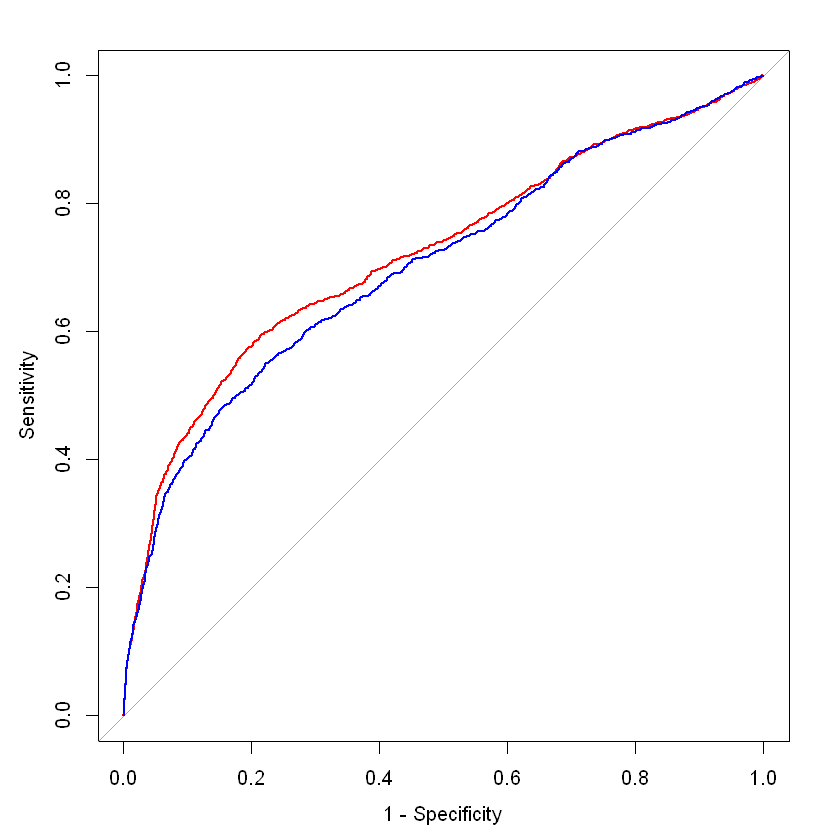

In [11]:
library(pROC)
library(caret)
confusionMatrix(as.factor(round(control_prediction_log,0)),as.factor(test$y),positive = "1")
confusionMatrix(as.factor(round(campaign_prediction_log,0)),as.factor(test$y), positive = "1")

roc.log.control <- roc(test$y ~ control_prediction_log)
roc.log.campaign <- roc(test$y ~ campaign_prediction_log)
plot(roc.log.control, legacy.axes = T,  col="red")
plot(roc.log.campaign, legacy.axes = T, add=T, col="blue")
(auc.log.control <- auc(roc.log.control))
(auc.log.campaign <- auc(roc.log.campaign))


In overall the first model (control group) has significantly higher accuracy, but really low sensitivity. This leads to many FN errors from the control group model. On the other hand the second model (campaign group) is more balanced, but the overall accuracy is lower. Both AUC and ROC imply that control model is better fitted to the testing data. Here a different cutoff point (different than 0,5 assumed) could be used to increase the sensitivity, but I will leave it as is for now, as I expect my second attempt to be more effective. **As the next step I would like to calculate what is the impact of using the model vs randomly picking the customers**. To do so I assumed couple of business metrics: 
<ol>
<li>revenue - lifelong revenue from a client</li>
<li>cost - hypothetical cost of contacting a client</li>
<li>budget - fixed budget for the marketing campaign</li>
</ol>

In [12]:
revenue <- 1000
cost <- 100
budget <- 100*2000

Firstly, I am calculating the profit given random choice of 2000 customers

In [13]:
targeting_random <- as.data.frame(campaign_prediction_log)
targeting_random <- targeting_random %>%
  filter(campaign_prediction_log<=1) # filtering out the NAs
targeting_random$x <- 1:nrow(targeting_random)
set.seed(1);targeting_random <- sample_n(targeting_random,budget/cost) %>%
mutate(outcome=round(campaign_prediction_log,0), profit = outcome*revenue-100) %>%
  summarise(total_profit = sum(profit))
print(targeting_random)

  total_profit
1       284000


The profit from random choice equals 284,000, but we still have to remember that my model didn't show any negative effect of contacting a client - meaning anyone campaigned would have positive uplift in probability of buying a product. Next I will calculate the profit using top 2000 cases (top in terms of uplift).

In [14]:
targeting_best <- as.data.frame(campaign_prediction_log)
targeting_best <- targeting_best %>%
  filter(campaign_prediction_log<=1) # filtering out the NAs
targeting_best$x <- 1:nrow(targeting_best)
targeting_best <- targeting_best %>%
  arrange(desc(campaign_prediction_log)) %>%
  top_n(2000) %>%
  mutate(outcome=round(campaign_prediction_log,0), profit = outcome*revenue-100) %>%
  summarise(total_profit = sum(profit))
print(targeting_best)

Selecting by x


  total_profit
1      1705000


Using the model to choose the clients gives approximately **5 times better results** than random choice.

In [15]:
(increased_profit <- (targeting_best-targeting_random)/targeting_random)

total_profit
5.003521


# Random Forest (two-model approach)

As I mentioned before I will try to use different method which might be better suited to the dataset. I chose to go with **random forest, but the overall approach of comparing two models doesn't change**. I need to get rid of the observations including NAs, as they are not operated with the random forest from randomForest package.

In [16]:
library(randomForest)
train.rf.control<- na.omit(train[test_control_flag=="control group",-c("test_control_flag","contact","month","day_of_week","duration","campaign")])
train.rf.campaign<- na.omit(train[test_control_flag=="campaign group",-c("test_control_flag","contact","month","day_of_week","duration","campaign")])


rf.control <- randomForest(x = train.rf.control[,-c("y")],
                         y = as.factor(train.rf.control[,y]),
                         ntree = 200, importance = F)

rf.campaign <- randomForest(x= train.rf.campaign[,-c("y")],
                            y = as.factor(train.rf.campaign[,y]),
                            ntree = 200, importance = F)

rf.test <- na.omit(test[,-c("test_control_flag","contact","month","day_of_week","duration","campaign")])


Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



I changed the initial parameters of the random forests basing on trial and error method. This could still be improved, but the gain won't be significant. Next I predict y outcomes and create similar histogram of the uplift (difference between predictions basing on two models).

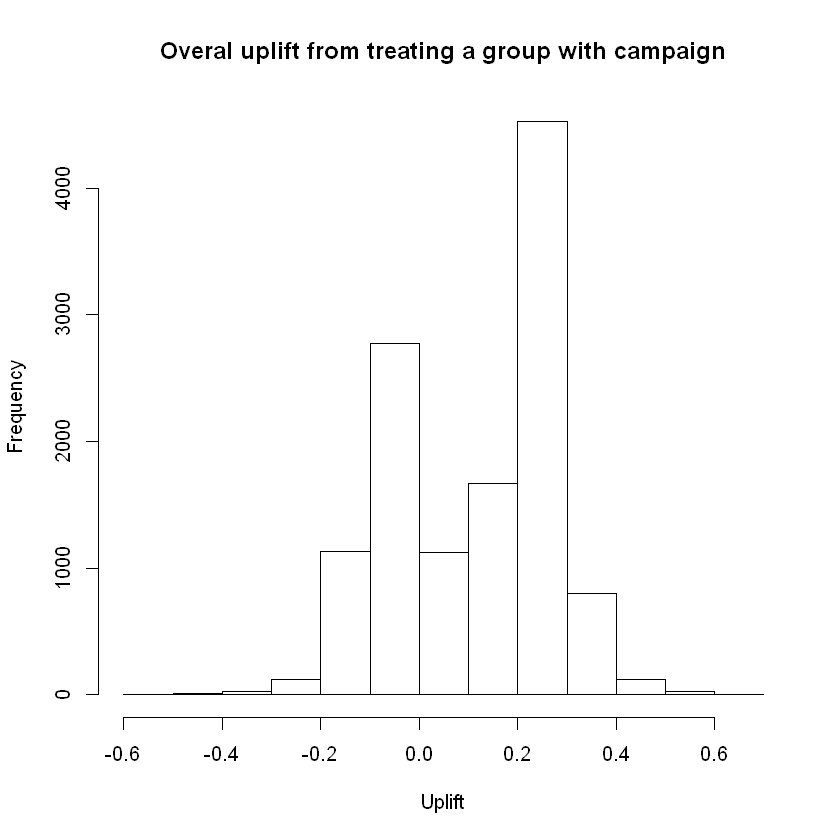

In [17]:
control_prediction_rf <- predict(rf.control,newdata = rf.test[,-c("y")], type= "prob")
control_prediction_rf <- control_prediction_rf[,"1"]
campaign_prediction_rf <- predict(rf.campaign,newdata = rf.test[,-c("y")], type= "prob")  
campaign_prediction_rf <- campaign_prediction_rf[,"1"]

hist(campaign_prediction_rf-control_prediction_rf,main = "Overal uplift from treating a group with campaign", xlab = "Uplift")


Interestingly it seems **there is actually a negative effect of campaigning specific clients**. It's intuitive and can be described by an example of emailing to a *Netflix* client with a new pricing offer which might remind them that they don't use the service anymore and decide to opt out from the subscribtion. In this case campaigning incorrect clients has negative effect on the profit (generates both costs and decrease revenue). Now I will compare the random forests models with logistic regression. 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10928  1074
         1   156   168
                                          
               Accuracy : 0.9002          
                 95% CI : (0.8948, 0.9054)
    No Information Rate : 0.8992          
    P-Value [Acc > NIR] : 0.3667          
                                          
                  Kappa : 0.1804          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.13527         
            Specificity : 0.98593         
         Pos Pred Value : 0.51852         
         Neg Pred Value : 0.91051         
             Prevalence : 0.10076         
         Detection Rate : 0.01363         
   Detection Prevalence : 0.02629         
      Balanced Accuracy : 0.56060         
                                          
       'Positive' Class : 1               
                  

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10721   896
         1   363   346
                                          
               Accuracy : 0.8979          
                 95% CI : (0.8924, 0.9032)
    No Information Rate : 0.8992          
    P-Value [Acc > NIR] : 0.7007          
                                          
                  Kappa : 0.3037          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.27858         
            Specificity : 0.96725         
         Pos Pred Value : 0.48801         
         Neg Pred Value : 0.92287         
             Prevalence : 0.10076         
         Detection Rate : 0.02807         
   Detection Prevalence : 0.05752         
      Balanced Accuracy : 0.62292         
                                          
       'Positive' Class : 1               
                  

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in par(xpd = xpd):
"pojawiły się wartości NA na skutek przekształcenia"

Area under the curve: 0.7699

Area under the curve: 0.7308

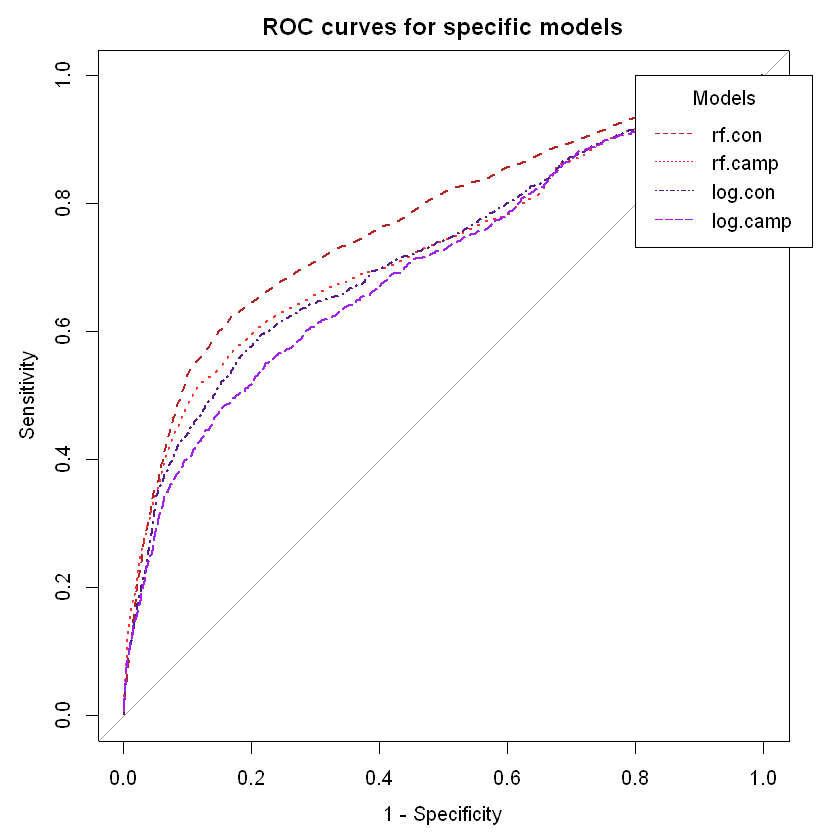

In [18]:
confusionMatrix(as.factor(round(control_prediction_rf,0)),as.factor(rf.test$y),positive = "1")
confusionMatrix(as.factor(round(campaign_prediction_rf,0)),as.factor(rf.test$y), positive = "1")

roc.rf.control <- roc(rf.test$y ~ control_prediction_rf)
roc.rf.campaign <- roc(rf.test$y ~ campaign_prediction_rf)
plot(roc.rf.control, legacy.axes = T,  col="firebrick",lty = 2, main = "ROC curves for specific models")
plot(roc.rf.campaign, legacy.axes = T, add=T, col="firebrick1", lty = 3)
plot(roc.log.control, legacy.axes = T, add=T,  col="purple4", lty = 4)
plot(roc.log.campaign, legacy.axes = T, add=T, col="purple", lty = 5)
legend(0.2,1, legend = c("rf.con", "rf.camp","log.con","log.camp"),
        lty = c(2,3,4,5),
        col = c("firebrick","firebrick1","purple4","purple"),
        title = "Models",xpd="NA")

(auc.rf.control <- auc(roc.rf.control))
(auc.rf.campaign <- auc(roc.rf.campaign))


Two random forest models are more similar two each other in terms of sensitivity and specificity, which will increase the accuracy of the calculated uplift as differences between probs from models. On the ROC curve we can see that AUC is higher for both submodels (control, campaign). Next step is similar to the previous, I calculate the profit from random choice and model-determined selection.

In [19]:
targeting_random2 <- as.data.frame(campaign_prediction_rf)
targeting_random2$x <- 1:nrow(targeting_random2)
set.seed(1);targeting_random2 <- sample_n(targeting_random2,budget/cost) %>%
  mutate(outcome=round(campaign_prediction_rf,0), profit = outcome*revenue-100) %>%
  summarise(total_profit = sum(profit))
print(targeting_random2)

  total_profit
1       -62000


So here is what we should expect. **Random selection not only isn't effective, it actually costs a lot**. On the other hand we can use the model to select the customers basing on the top uplift. First I will use all the marketing budget to do so.

In [20]:
uplift <- campaign_prediction_rf-control_prediction_rf
targeting_best2 <- data.frame(uplift,campaign_prediction_rf)
targeting_best2$x <- 1:nrow(targeting_best2)
targeting_best2 <- targeting_best2 %>%
  arrange(desc(uplift)) %>%
  top_n(2000) %>%
  mutate(outcome=round(campaign_prediction_rf,0), profit = outcome*revenue-100) %>%
  summarise(total_profit = sum(profit))
print(targeting_best2)
(increased_profit2 <- targeting_best2-targeting_random2)

Selecting by x


  total_profit
1       194000


total_profit
256000


Using model to assess potential targets of marketing campaign gives us **+256000 instead of -62000**. However, if we have a negative effect we might consider cutting the number of targets below the maximum enabled by the budget. 

In [21]:
uplift <- campaign_prediction_rf-control_prediction_rf
targeting_best2 <- data.frame(uplift,campaign_prediction_rf)
targeting_best2$x <- 1:nrow(targeting_best2)
targeting_best2 <- targeting_best2 %>%
  arrange(desc(uplift)) %>%
  top_n(900) %>%
  mutate(outcome=round(campaign_prediction_rf,0), profit = outcome*revenue-100) %>%
  summarise(total_profit = sum(profit))
print(targeting_best2)
(increased_profit2 <- targeting_best2-targeting_random2)

Selecting by x


  total_profit
1       273000


total_profit
335000


Again basing on the trial and error method targeting only 900 top-prospect clients is more profitable. This concludes my solution which gives a proof of concept for establishing a model predicting whom to address with marketing campaign in our hypothetical situation. 

**My solution could be further enhanced in several ways**:
<ol>
<li>tuning all models to have better sensitivity (especially the potential of playing with variables in log regression, so that it's more useful)</li>
<li>using causal random forest, which is not that intuitive, but highly effective - as suggested by the literature</li>
<li>building campaign models using marketing campaign data (contact, month, day_of_week, duration, campaign) - which I omitted in my solution</li>
<li>estimating the actual number of people to address more precisely</li>
<li>building next model assessing what kind of contact is more appropriate to the specific client (exact day of week or communication type, to increase the uplift)</li>
</ol>